In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import numpy as np
from scipy.signal import find_peaks
from database.settings import Settings
from database.model import MesureL3

pid_list = ['40TthyR8Qo', '40Tu0j67D4', '40TtYb6e2e']

In [2]:
database_settings = Settings()
engine = database_settings.get_engine()
query = MesureL3.get_query(pid_list)
df = pd.read_sql(query, con=engine)
df = df.pivot(index='timestamp', columns='probe_id', values='value')
df.index = pd.to_datetime(df.index)
df

probe_id,40TtYb6e2e,40TthyR8Qo,40Tu0j67D4
timestamp,,,
2019-01-07 00:00:00+00:00,0.4,0.4,0.1
2019-01-13 00:00:00+00:00,-3.6,0.9,-0.7
2019-01-19 00:00:00+00:00,-0.7,1.1,-1.0
2019-01-25 00:00:00+00:00,-0.6,-0.2,-0.5
2019-01-31 00:00:00+00:00,3.1,1.7,0.5
...,...,...,...
2023-11-24 00:00:00+00:00,7.8,0.9,0.5
2023-11-30 00:00:00+00:00,10.8,0.9,-0.5
2023-12-06 00:00:00+00:00,14.3,0.7,-1.5


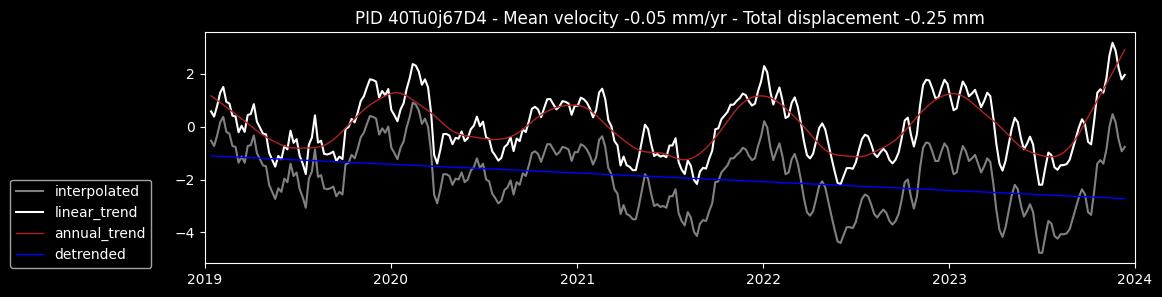

In [3]:
data_season = []
for col in df.columns:
    data = df[col]
    resampled = data.resample('6D').asfreq()
    interpolated = resampled.interpolate(method='linear')
    interpolated = interpolated.rolling(window=3, center=True).mean().dropna()

    # Extraire la tendance pluriannuelle (pente de la droite)
    # Modélisation de la droite
    a, b = np.polyfit(interpolated.index.map(pd.Timestamp.toordinal), interpolated.values, 1)

    # Convertion la pente de la droite en vitesse moyenne de déplacement en mm/an
    slope = round(a / 6 * 365.25, 2)
    total_displacement = slope * 5

    # Recalcul des valeurs à partir du modèle linéaire
    linear_trend = a * interpolated.index.map(pd.Timestamp.toordinal) + b

    # Soustraction de la tendance aux données brutes
    detrended = interpolated - linear_trend

    # Extraction de la tendance saisonnière annuelle
    stl = STL(detrended, trend=31)
    result = stl.fit()
    annual_trend = result.trend
    data_season.append(annual_trend)

    plt.figure(figsize=(12, 3))

    plt.plot(interpolated, linewidth=1.5, color='grey')
    plt.plot(detrended, linewidth=1.5, color='white')
    plt.plot(annual_trend, linewidth=1, color='firebrick')
    plt.plot(interpolated.index, linear_trend, linewidth=1, color='blue')

    plt.legend(['interpolated', 'linear_trend', 'annual_trend', 'detrended'], loc='lower right',
               bbox_to_anchor=(-0.05, -0.05))
    plt.title(f'PID {col} - Mean velocity {slope} mm/yr - Total displacement {total_displacement} mm')
    plt.xlim(pd.to_datetime('2019-01-01'), pd.to_datetime('2024-01-01'))
    plt.show()

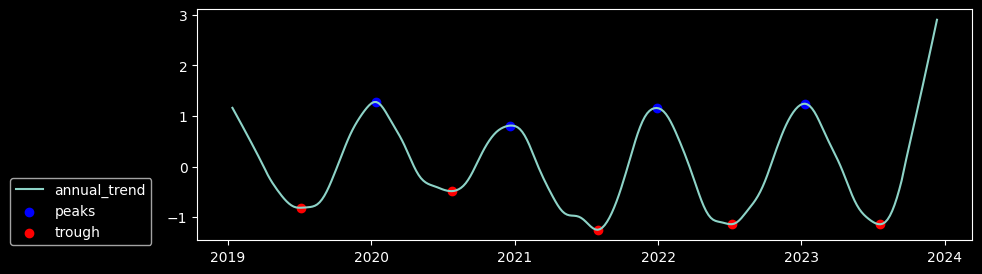

In [4]:
for data in data_season:
    peaks, _ = find_peaks(data, prominence=1, distance=None)
    troughs, _ = find_peaks(-data, prominence=1, distance=None)
    peak_values = data.iloc[peaks]
    trough_values = data.iloc[troughs]
    dates = data.index.date
    peak_dates = dates[peaks]
    trough_dates = dates[troughs]

    # Make DataFrames for easy matching
    peak_df = pd.DataFrame({'date': peak_dates, 'value': peak_values, 'type': 'peak'})
    trough_df = pd.DataFrame({'date': trough_dates, 'value': trough_values, 'type': 'trough'})

    plt.figure(figsize=(10, 3))
    plt.plot(data)
    plt.scatter(peak_df['date'], peak_df['value'], color='blue')
    plt.scatter(trough_df['date'], trough_df['value'], color='red')

    plt.legend(['annual_trend', 'peaks', 'trough'], loc='lower right', bbox_to_anchor=(-0.05, -0.05))
    plt.show()